In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import pathlib as pl

working_directory = pl.Path("..").resolve()
working_directory

PosixPath('/home/lars/Documents/code/python/bayesflow')

In [3]:
import sys

if str(working_directory) not in sys.path:
    sys.path.append(str(working_directory))

In [4]:
import bayesflow as bf
import keras
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class GaussianSimulator(bf.simulators.Simulator):
    def __init__(self, dim=2):
        self.dim = dim
    
    def sample(self, batch_shape, num_obs=128):
        mean = np.random.normal(0.0, 2.0, size=batch_shape + (self.dim,))
        std = np.random.uniform(0.5, 2.0, size=batch_shape + (self.dim,)) 
        obs = np.random.normal(mean[:, None], std[:, None], size=batch_shape + (num_obs, self.dim))
        
        return dict(mean=mean, std=std, obs=obs)

In [6]:
simulator = GaussianSimulator()

In [7]:
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["mean", "std"],
    summary_variables=["obs"]
)

In [8]:
inference_network = bf.networks.FlowMatching(
    subnet="mlp",
    subnet_kwargs=dict(
        depth=4,
        width=256,
        dropout=None,
        activation="relu"
    ),
    use_optimal_transport=True,
)

In [9]:
summary_network = bf.networks.DeepSet(
    summary_dim=32,
    depth=2,
    dropout=None,
    activation="relu",
)

In [10]:
approximator = bf.ContinuousApproximator(
    data_adapter=data_adapter,
    inference_network=inference_network,
    summary_network=summary_network,
)

In [11]:
epochs = 32
training_batches = 64
validation_batches = 16
batch_size = 128

In [12]:
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=epochs * training_batches,
    alpha=1e-3,
)

In [13]:
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate,
    clipnorm=1.0,
    # use some weight decay since we train offline
    weight_decay=0.01,
)

In [14]:
approximator.compile(optimizer=optimizer)

In [15]:
training_data = simulator.sample((training_batches * batch_size,))
validation_data = simulator.sample((validation_batches * batch_size,))

In [16]:
training_dataset = bf.datasets.OfflineDataset(
    batch_size=batch_size,
    data=training_data,
    data_adapter=data_adapter,
)

In [17]:
validation_dataset = bf.datasets.OfflineDataset(
    batch_size=batch_size,
    data=validation_data,
    data_adapter=data_adapter,
)

In [18]:
approximator.fit(
    batch_size=batch_size,
    epochs=epochs,
    dataset=training_dataset,
    validation_data=validation_dataset,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 1.7830 - loss/inference_loss: 1.7830 - val_loss: 1.2038 - val_loss/inference_loss: 1.2038
Epoch 2/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 1.0678 - loss/inference_loss: 1.0678 - val_loss: 1.0548 - val_loss/inference_loss: 1.0548
Epoch 3/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 0.8509 - loss/inference_loss: 0.8509 - val_loss: 0.7249 - val_loss/inference_loss: 0.7249
Epoch 4/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - loss: 0.7012 - loss/inference_loss: 0.7012 - val_loss: 0.6771 - val_loss/inference_loss: 0.6771
Epoch 5/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 0.6196 - loss/inference_loss: 0.6196 - val_loss: 0.5249 - val_loss/inference_loss: 0.5249
Epoch 6/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - loss: 0.5764 - loss/inference_loss: 0.5764 - val_loss: 0.5449 - val_loss/inference_loss: 0.5449
Epoch 7/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 0.5061 - loss/inference_loss: 0.5061 - v

In [25]:
# generate 16 samples, each with 1024 observations
test_data = simulator.sample((16,), num_obs=1024)

conditions = {
    "obs": test_data["obs"]
}

samples = approximator.sample(batch_shape=(16,), conditions=conditions)

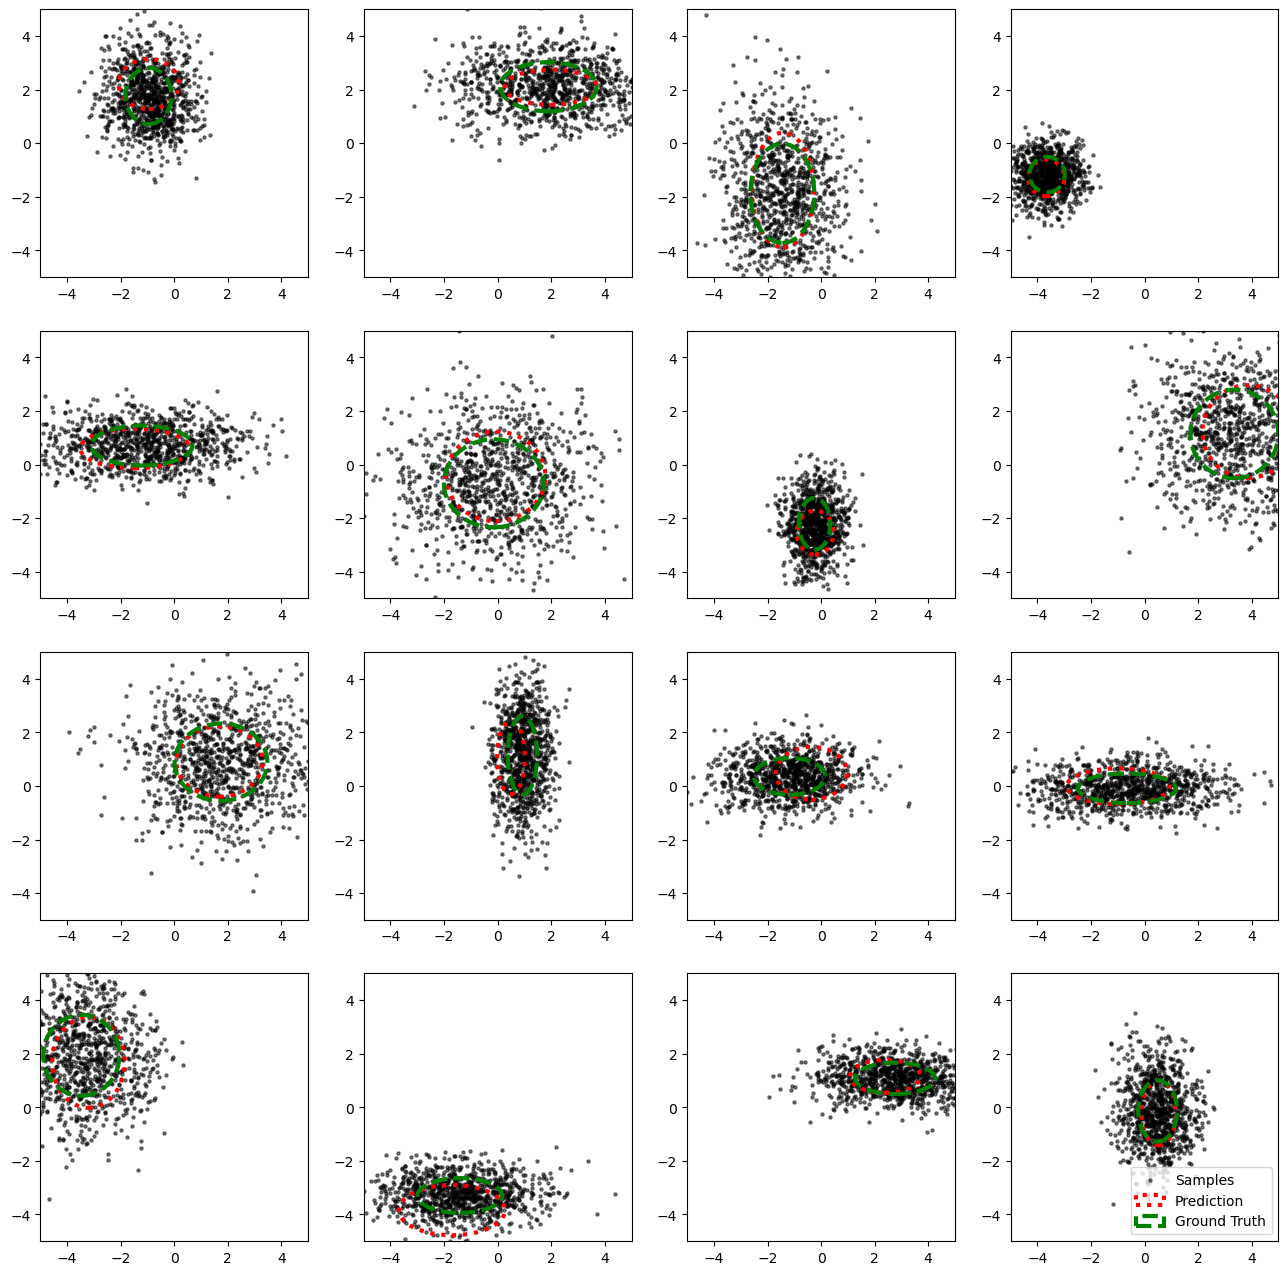

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, ax in enumerate(axes.flat):
    x, y = conditions["obs"][i, :, 0:2].T
    ax.scatter(x, y, s=5, color="black", alpha=0.5, label="Samples")
    
    # predictions in red
    mean, std = samples["mean"][i, 0:2], samples["std"][i, 0:2]
    ax.add_artist(matplotlib.patches.Ellipse(mean, 2 * std[0], 2 * std[1], color="red", fill=False, ls=":", lw=3, label="Prediction"))
    
    # true values in green
    mean, std = test_data["mean"][i, 0:2], test_data["std"][i, 0:2]
    ax.add_artist(matplotlib.patches.Ellipse(mean, 2 * std[0], 2 * std[1], color="green", fill=False, ls="--", lw=3, label="Ground Truth"))
    
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect("equal", adjustable="box")

plt.legend(loc="lower right")
plt.show()